In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Defining the fit algorithm (Levenberg-Marquadt)

Since I faced some problems with the linear least-squares fit, I decided to use a non-linear method. The original code for this method was taken from Jon's codes for Phys512 course (version 2021) which I had last year. 

The Gaussian function that is defined hereunder, relies on 4 parameters.

In [2]:
def gauss(m,x):
    #get y=a+b*exp((x-x0)^2/2sig^2)
    a=m[0]
    b=m[1]
    x0=m[2]
    sig=m[3]
    expvec=np.exp(-0.5*(x-x0)**2/sig**2)
    y=a+b*expvec
    derivs=np.empty([len(x),len(m)])
    derivs[:,0]=1
    derivs[:,1]=expvec
    derivs[:,2]=b*(x-x0)*2/(2*sig**2)*expvec
    derivs[:,3]=b*(0.5*(x-x0)**2)*2/sig**3*expvec

    return y,derivs

def update_lamda(lamda,success):
    if success:
        lamda=lamda/1.5
        if lamda<0.5:
            lamda=0
    else:
        if lamda==0:
            lamda=1
        else:
            lamda=lamda*1.5**2
    return lamda

def get_matrices(m,fun,x,y,Ninv=None):
    model,derivs=fun(m,x)
    r=y-model
    if Ninv is None:
        lhs=derivs.T@derivs
        rhs=derivs.T@r
        chisq=np.sum(r**2)
    else:
        lhs=derivs.T@Ninv@derivs
        rhs=derivs.T@(Ninv@r)
        chisq=r.T@Ninv@r
    return chisq,lhs,rhs

def linv(mat,lamda):
    mat=mat+lamda*np.diag(np.diag(mat))
    return np.linalg.pinv(mat)

def fit_lm(m,fun,x,y,Ninv=None,niter=10,chitol=0.01):
#levenberg-marquardt fitter that doesn't wastefully call extra
#function evaluations, plus supports noise
    lamda=0
    chisq,lhs,rhs=get_matrices(m,fun,x,y,Ninv)
    for i in range(niter):
        lhs_inv=linv(lhs,lamda)
        dm=lhs_inv@rhs
        chisq_new,lhs_new,rhs_new=get_matrices(m+dm,fun,x,y,Ninv)
        if chisq_new<chisq:  
            #accept the step
            #check if we think we are converged - for this, check if 
            #lamda is zero (i.e. the steps are sensible), and the change in 
            #chi^2 is very small - that means we must be very close to the
            #current minimum
            if lamda==0:
                if (np.abs(chisq-chisq_new)<chitol):
                    #print(np.abs(chisq-chisq_new))
                    #print('Converged after ',i,' iterations of LM')
                    return m+dm
            chisq=chisq_new
            lhs=lhs_new
            rhs=rhs_new
            m=m+dm
            lamda=update_lamda(lamda,True)
            
        else:
            lamda=update_lamda(lamda,False)
        #print('on iteration ',i,' chisq is ',chisq,' with step ',dm,' and lamda ',lamda)
    return m

def chi_square(obs, exp): # to measure the quality of fit (cacualte the bias)
    return np.sum(((obs-exp)**2)/exp)

# Generating the data Set

In order to generate the data sets, I use my "gauss" function and add noise using np.random.randn

In [3]:
x = np.linspace(-5,5,51)
m_true = np.asarray([0, 1, 0, 1]) #the original set of params to generate data
y_true, derivs = gauss(m_true,x) #the noise-free data
n_chunk = 10000 #number of chunks

def generate_data(n_chunk, x, y_true): #generates an arbitary number of noisy data sets and stores them in a 2D array
    signal = np.zeros((n_chunk, len(x)))
    noise = np.random.randn(n_chunk, len(x))
    var = np.zeros((n_chunk))
    
    for i in range(n_chunk):
        signal[i, :] = y_true + noise[i, :] #calculating the noisy data
        var[i] = np.var(signal[i, :])     #calculating the noise on data
        # Since we assumed that noise is constant within a chunk and is equal to the scatter in the observed data
    return signal, var

# y is the noisy data and var is the noise
y, var = generate_data(n_chunk, x, y_true)

m0 = m_true + np.random.randn(len(m_true))*1.0
m_fit_many = np.zeros((n_chunk, len(m_true)))
y_fit_many = np.zeros((n_chunk, len(x)))
for i in range(n_chunk):
    m_fit = fit_lm(m0, gauss, x, y[i, :], niter=20)
    m_fit_many[i, :] = m_fit #the matrix which includes the value of fitted params for each chunk
    y_fit, derivs = gauss(m_fit,x)
    y_fit_many[i, :] = y_fit #the matrix which includes the values of fitted gaussian curves for each chunk
 

# Sample fit

Plotting the fit for one of the chunks as a sample

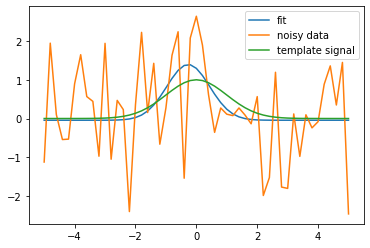

In [15]:
sample = 7502 # an arbitary sample number
plt.plot(x, y_fit_many[sample, :], label="fit")
plt.plot(x, y[sample, :], label="noisy data")
plt.plot(x, y_true, label='template signal')
plt.legend()
plt.show()

# Overall fit

To find the weighted average over all of the chunks

In [5]:
# the wights for the weighted average are w_i = sigma_i ^ -2/ var ^-2
w = var **(-2)
w_t = np.sum(w)
temp = np.zeros((n_chunk, len(x)))
summation = np.zeros(len(x))
average = np.zeros(len(x))
for i in range(n_chunk):
    temp[i, :] = w [i] * y_fit_many[i, :]
for i in range(len(x)):
    summation[i] = np.sum (temp[:, i])
    average [i] = summation [i]/w_t

The chi-square for this fit is:  9146.866933848729


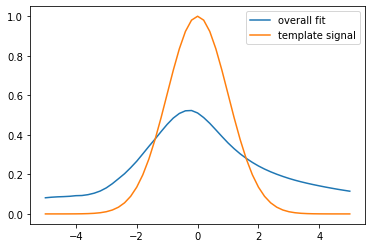

In [6]:
print('The chi-square for this fit is: ', repr(chi_square(average, y_true)))
plt.plot(x, average, label='overall fit')
plt.plot(x, y_true, label='template signal')
plt.legend()
plt.show()

My individual chunk fits were also a bit biased. However, the bias on overall weighted avergard signal is much more than those (With regard to chi-square values).